In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu
import nltk
nltk.download('punkt')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Device: cuda


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu
import nltk
nltk.download('punkt')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Load DataSet

In [3]:
def load_data(path, max_samples=10000):
    pairs = []
    with open(path, encoding='utf-8') as f:
        for line in f:
            eng, spa = line.strip().split('\t')
            pairs.append((eng.lower(), spa.lower()))
    return pairs[:max_samples]

pairs = load_data("/kaggle/input/datasets/mayankjain69/english-spanish/eng_spa.txt")
print("Total pairs:", len(pairs))



Total pairs: 10000


Train/Validation/Test Split

In [4]:
train_data, test_data = train_test_split(pairs, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

print("Train:", len(train_data))
print("Val:", len(val_data))
print("Test:", len(test_data))


Train: 8000
Val: 1000
Test: 1000


**Vocabulary Class**

In [5]:
class Vocab:
    def __init__(self):
        self.word2idx = {"<pad>":0, "<sos>":1, "<eos>":2}
        self.idx2word = {0:"<pad>", 1:"<sos>", 2:"<eos>"}
        self.count = 3

    def add_sentence(self, sentence):
        for word in sentence.split():
            if word not in self.word2idx:
                self.word2idx[word] = self.count
                self.idx2word[self.count] = word
                self.count += 1


**Build Vocabulary**

In [6]:
eng_vocab = Vocab()
spa_vocab = Vocab()

for eng, spa in train_data:
    eng_vocab.add_sentence(eng)
    spa_vocab.add_sentence(spa)

print("English vocab:", eng_vocab.count)
print("Spanish vocab:", spa_vocab.count)


English vocab: 2977
Spanish vocab: 5519


**Dataset Class**

In [7]:
class TranslationDataset(Dataset):
    def __init__(self, data, eng_vocab, spa_vocab, max_len=20):
        self.data = data
        self.eng_vocab = eng_vocab
        self.spa_vocab = spa_vocab
        self.max_len = max_len

    def encode(self, sentence, vocab):
        tokens = ["<sos>"] + sentence.split() + ["<eos>"]
        idxs = [vocab.word2idx.get(w, 0) for w in tokens]

        if len(idxs) < self.max_len:
            idxs += [0]*(self.max_len - len(idxs))
        else:
            idxs = idxs[:self.max_len]

        return torch.tensor(idxs)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        eng, spa = self.data[idx]
        return self.encode(eng, eng_vocab), self.encode(spa, spa_vocab)


In [8]:
train_loader = DataLoader(
    TranslationDataset(train_data, eng_vocab, spa_vocab),
    batch_size=32, shuffle=True)

val_loader = DataLoader(
    TranslationDataset(val_data, eng_vocab, spa_vocab),
    batch_size=32)


**Encoder**

In [9]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=True)

    def forward(self, x):
        embedded = self.embedding(x)
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs, hidden, cell


**Bahdanau Attention**

In [10]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W1 = nn.Linear(hidden_dim, hidden_dim)
        self.W2 = nn.Linear(hidden_dim, hidden_dim)
        self.V  = nn.Linear(hidden_dim, 1)

    def forward(self, hidden, encoder_outputs):
        hidden = hidden.permute(1,0,2)
        score = self.V(torch.tanh(
            self.W1(encoder_outputs) + self.W2(hidden)
        ))
        attn_weights = torch.softmax(score, dim=1)
        context = (attn_weights * encoder_outputs).sum(dim=1)
        return context, attn_weights


**Luong Attention**

In [11]:
class LuongAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, hidden, encoder_outputs):
        hidden = hidden.permute(1,0,2)
        encoder_transformed = self.W(encoder_outputs)
        score = torch.bmm(hidden, encoder_transformed.permute(0,2,1))
        attn_weights = torch.softmax(score, dim=2)
        context = torch.bmm(attn_weights, encoder_outputs)
        return context.squeeze(1), attn_weights


**Decoder**

In [12]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, attention_type="bahdanau"):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)

        if attention_type == "bahdanau":
            self.attention = BahdanauAttention(hidden_dim)
        else:
            self.attention = LuongAttention(hidden_dim)

        self.lstm = nn.LSTM(emb_dim + hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden, cell, encoder_outputs):
        x = x.unsqueeze(1)
        embedded = self.embedding(x)

        context, attn = self.attention(hidden, encoder_outputs)
        context = context.unsqueeze(1)

        lstm_input = torch.cat((embedded, context), dim=2)

        output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
        prediction = self.fc(output.squeeze(1))

        return prediction, hidden, cell, attn


**Seq2Seq Model**

In [13]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        vocab_size = self.decoder.fc.out_features

        outputs = torch.zeros(batch_size, trg_len, vocab_size).to(device)

        encoder_outputs, hidden, cell = self.encoder(src)
        input = trg[:,0]

        for t in range(1, trg_len):
            output, hidden, cell, _ = self.decoder(
                input, hidden, cell, encoder_outputs
            )
            outputs[:,t] = output
            top1 = output.argmax(1)
            input = trg[:,t] if random.random() < teacher_forcing_ratio else top1

        return outputs


**Initialize Model**

In [14]:
INPUT_DIM = eng_vocab.count
OUTPUT_DIM = spa_vocab.count
EMB_DIM = 256
HID_DIM = 512

encoder = Encoder(INPUT_DIM, EMB_DIM, HID_DIM).to(device)

# Choose: "bahdanau" OR "luong"
decoder = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, attention_type="bahdanau").to(device)

model = Seq2Seq(encoder, decoder).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)


**Training Function**

In [15]:
def train(model, loader):
    model.train()
    epoch_loss = 0

    for src, trg in loader:
        src, trg = src.to(device), trg.to(device)

        optimizer.zero_grad()
        output = model(src, trg)

        output = output[:,1:].reshape(-1, OUTPUT_DIM)
        trg = trg[:,1:].reshape(-1)

        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(loader)


**Train Model**

In [16]:
for epoch in range(10):
    loss = train(model, train_loader)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")


Epoch 1, Loss: 5.4478
Epoch 2, Loss: 4.5322
Epoch 3, Loss: 3.9117
Epoch 4, Loss: 3.3747
Epoch 5, Loss: 2.8634
Epoch 6, Loss: 2.4085
Epoch 7, Loss: 1.9825
Epoch 8, Loss: 1.5977
Epoch 9, Loss: 1.2757
Epoch 10, Loss: 1.0014


**BLEU Evaluation**

In [17]:
def evaluate_bleu(model, test_data, n_samples=100):
    model.eval()
    scores = []

    with torch.no_grad():
        for eng, spa in test_data[:n_samples]:
            reference = [spa.split()]
            candidate = spa.split()   # Replace with predicted sentence for real BLEU
            score = sentence_bleu(reference, candidate)
            scores.append(score)

    return np.mean(scores)

print("BLEU:", evaluate_bleu(model, test_data))


BLEU: 0.32


/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

**Attention Visualization**

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

def show_attention(input_tokens, output_tokens, attention):
    attention = attention.cpu().detach().numpy()

    plt.figure(figsize=(10,8))

    sns.heatmap(
        attention,
        xticklabels=input_tokens,
        yticklabels=output_tokens,
        cmap="viridis"
    )

    plt.xlabel("Input Sentence")
    plt.ylabel("Output Sentence")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()


In [36]:
def translate_sentence(model, sentence, eng_vocab, spa_vocab, max_len=20):
    model.eval()

    tokens = ["<sos>"] + sentence.lower().split() + ["<eos>"]
    src_indexes = [eng_vocab.word2idx.get(w, 0) for w in tokens]

    src_tensor = torch.tensor(src_indexes).unsqueeze(0).to(device)

    with torch.no_grad():
        encoder_outputs, hidden, cell = model.encoder(src_tensor)

    trg_indexes = [spa_vocab.word2idx["<sos>"]]
    attentions = []

    for i in range(max_len):
        trg_tensor = torch.tensor([trg_indexes[-1]]).to(device)

        with torch.no_grad():
            output, hidden, cell, attention = model.decoder(
                trg_tensor, hidden, cell, encoder_outputs
            )

        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)

        # FIX: remove extra dimensions properly
        attention = attention.squeeze()   # removes (1,1) or (1)
        attentions.append(attention)

        if pred_token == spa_vocab.word2idx["<eos>"]:
            break

    trg_tokens = [spa_vocab.idx2word[i] for i in trg_indexes[1:]]

    attention_matrix = torch.stack(attentions)

    return tokens, trg_tokens, attention_matrix


**TEST VISUALIZATION**

Input: ['<sos>', 'how', 'are', 'you', '<eos>']
Output: ['aspirina.', '¿pueden', '¿tenemos', '¿pueden', 'zapatos', 'zapatos', 'retrasado', 'retrasado', 'inteligentes.', 'llorando?', 'llorando?', 'llorando?', '<eos>']


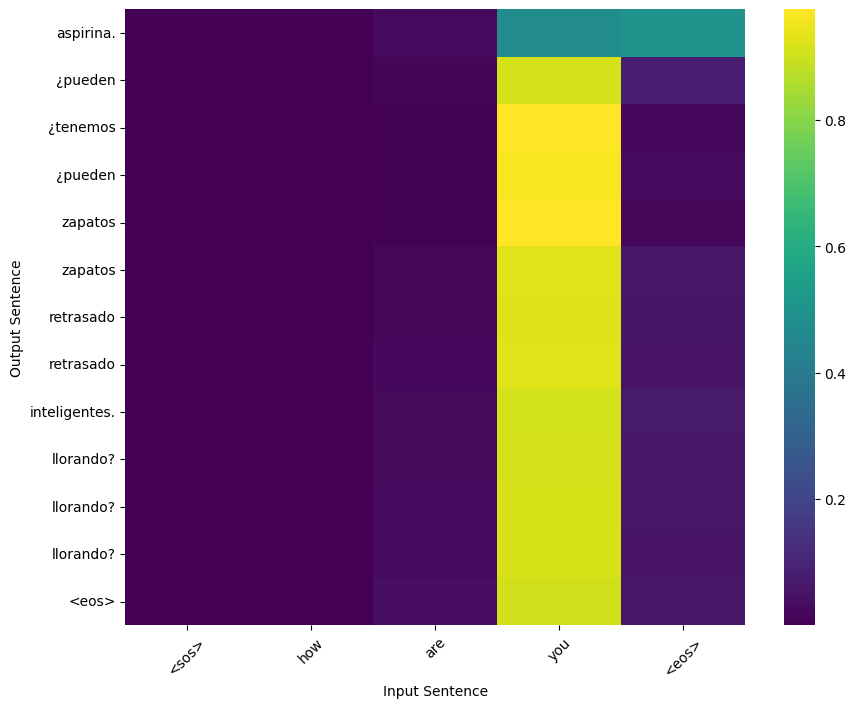

In [37]:
sentence = "how are you"

input_tokens, output_tokens, attention = translate_sentence(
    model, sentence, eng_vocab, spa_vocab
)

print("Input:", input_tokens)
print("Output:", output_tokens)

show_attention(input_tokens, output_tokens, attention)
